## Import Libraries

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')

import os
import pandas as pd
import pickle
import numpy as np
import csv
import scipy.misc
import scipy

from scipy import ndimage
import IPython.display as ipd
import cv2
import librosa
import librosa.display

# Sklearn Imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Neural Network Imports
from keras.models import Sequential
from keras.utils import np_utils, to_categorical
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# External pyython script imports
from clean_audio_data import *
from feature_extraction import *
from predict_audio import *
from live_audio import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading in Audio DataFrame + Cleaning

In [6]:
# Loads in dataframe using create_one_df function in clean_audio_data
df = create_one_df()

## Audio EDA

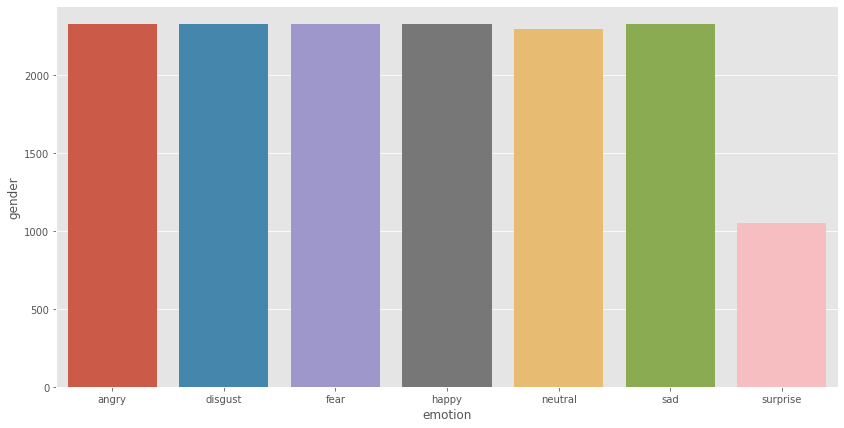

In [5]:
# We are specifically looking at the emotion counts over the 7 different emotions from the audio dataframe
emotion_count = pd.DataFrame(df.groupby('emotion').count()['gender']).reset_index()
fig, ax = plt.subplots(figsize = (14,7))

sns.barplot(x = emotion_count.emotion, y = emotion_count.gender)

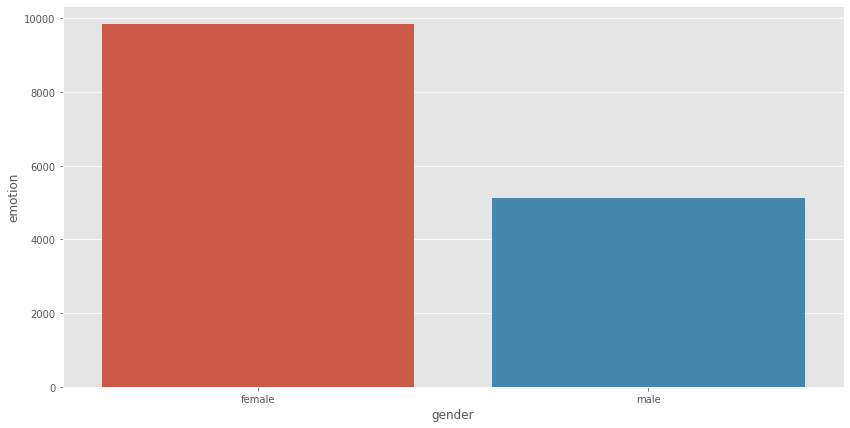

In [7]:
# We are specifically looking at the gender distribution within the audio data frame
gender_count = pd.DataFrame(df.groupby('gender').count()['emotion']).reset_index()
fig, ax = plt.subplots(figsize = (14,7))

sns.barplot(x = gender_count.gender, y = gender_count.emotion)

In [1]:
# We're looking at where the audio data is primarily coming from
data_source_count = pd.DataFrame(df.groupby('source').count()['gender']).reset_index()
fig, ax = plt.subplots(figsize = (14,7))

sns.barplot(x = data_source_count.source, y = data_source_count.gender)

NameError: name 'plt' is not defined

In [11]:
# Splitting up the female and male audio
female_audio = df[df['gender'] == 'female']
male_audio = df[df['gender'] == 'male']

In [13]:
# Setting up a dictionary for male and female audio to compare them against eachother
male_dict = {
'neutral' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav',
'happy' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-03-02-01-02-01.wav',
'sad' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-04-02-01-02-01.wav',
'angry' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-05-02-01-02-01.wav',
'fearful' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-06-02-01-02-01.wav',
'disgust' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-07-02-01-02-01.wav',
'surprised' : '../data/RAV/audio_speech_actors_01-24/Actor_01/03-01-08-02-01-02-01.wav',
}

female_dict = {
'neutral' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-02-02.wav',
'happy' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-03-02-01-02-02.wav',
'sad' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-04-02-01-02-02.wav',
'angry' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-05-02-01-02-02.wav',
'fearful' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-06-02-01-02-02.wav',
'disgust' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-07-02-01-02-02.wav',
'surprised' : '../data/RAV/audio_speech_actors_01-24/Actor_02/03-01-08-02-01-02-02.wav',
}

In [14]:
# Looking at a neutral example of male audio
audio_path = male_dict['neutral']
neutral , sr = librosa.load(audio_path)
ipd.Audio(audio_path)

In [15]:
# Looking at a neutral example of female audio
audio_path = female_dict['neutral']
neutral , sr = librosa.load(audio_path)
ipd.Audio(audio_path)

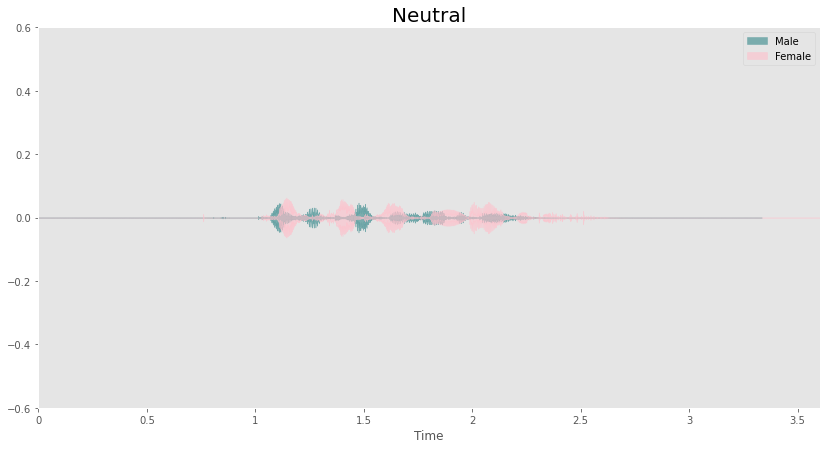

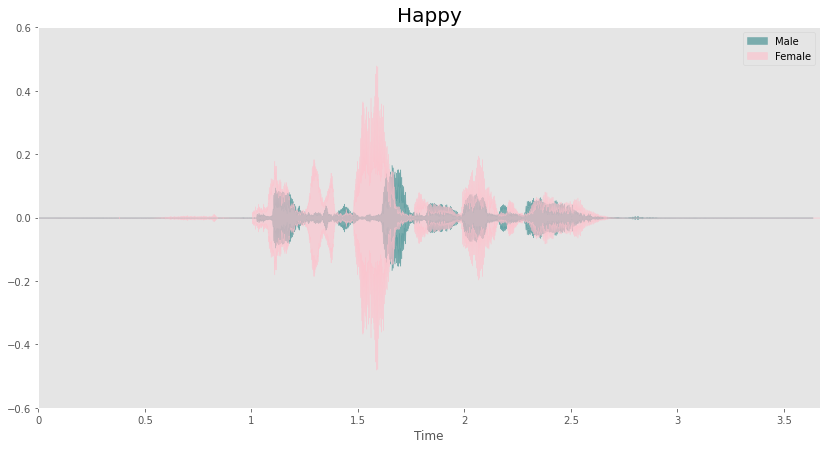

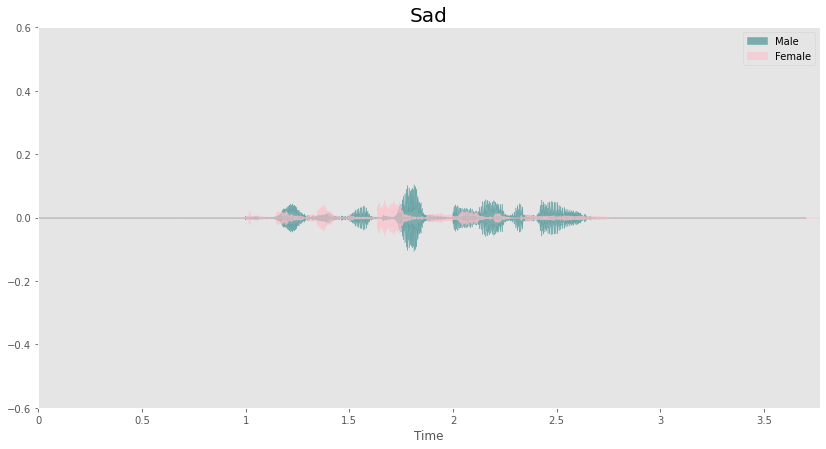

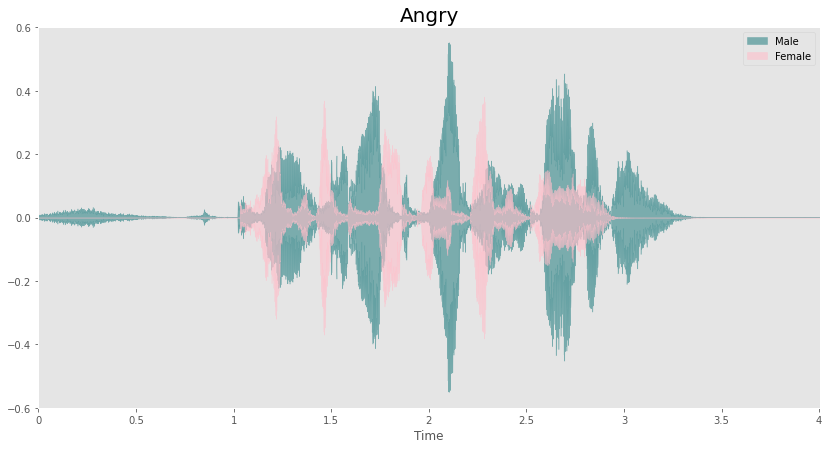

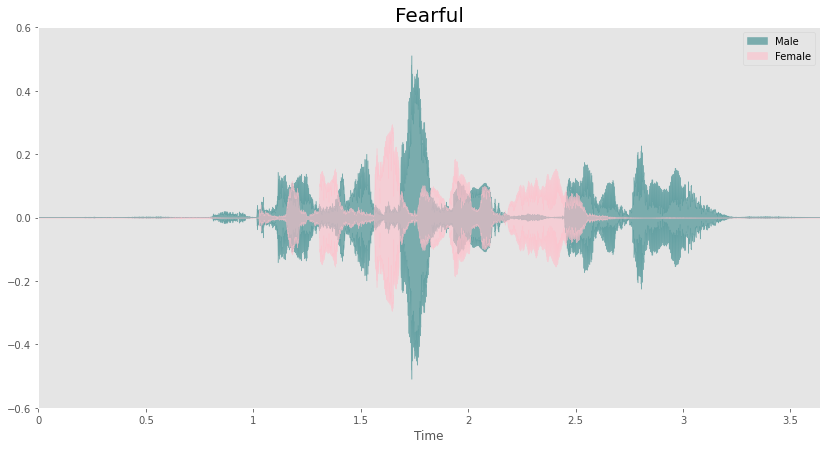

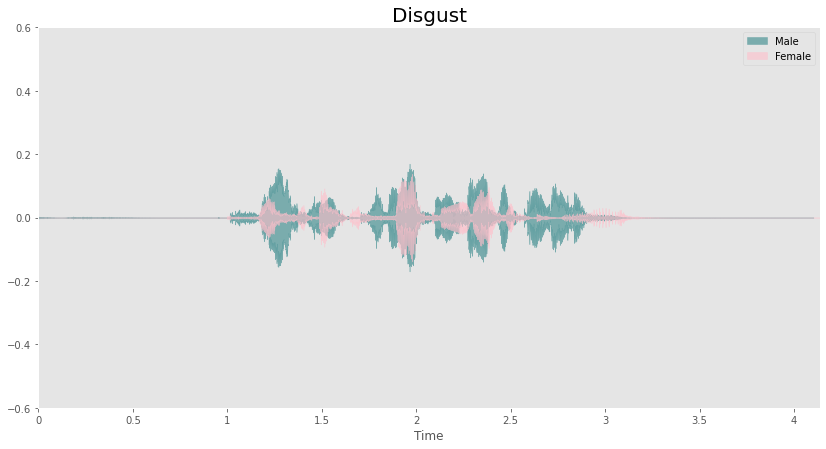

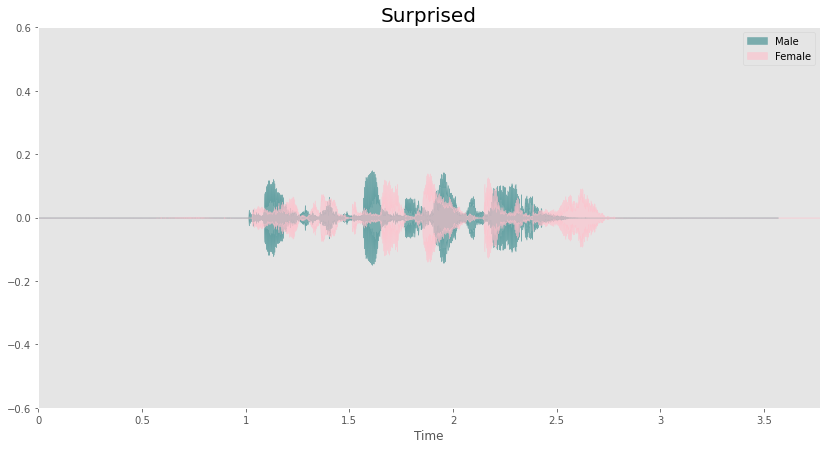

In [16]:
# Showing the wave plots between male and female audio for the seven emotions
for emotion in list(male_dict.keys()):
    fig, ax = plt.subplots(figsize = (14,7))
    y, sr = librosa.load(male_dict[emotion])
    y1, sr1 = librosa.load(female_dict[emotion])
    ax = librosa.display.waveplot(y, alpha=0.8, label='Male', color='cadetblue')
    ax = librosa.display.waveplot(y1, alpha=0.6, label='Female', color='pink')
    plt.grid(visible = False)
    plt.legend()
    plt.title(emotion.title(), fontsize = 20)
    plt.ylim(bottom=-.6, top=.6)

In [3]:
# Loading in the mfcc dataframe for all the audio files within the original audio dataframe
# This is done via the mfcc function in feature_extraction.py
df1 = pd.read_csv('../../data/mfcc_audio_df.csv')

In [12]:
# Setting X and y for predictive modeling (i.e. our neural networks)
df3 = df1.drop(['gender','emotion','source','path', 'true_label'], axis = 1)
y = df1.true_label

In [14]:
# Scaling the data
scaler = StandardScaler()

# Converting X into a format that can be inputted into a 1-D convolutional neural network
X = scaler.fit(np.array(df3.iloc[:, :-1], dtype = float))
X = scaler.transform(np.array(df3.iloc[:, :-1], dtype = float))
X = X.reshape(X.shape[0], X.shape[1],1)

In [15]:
# Saving our scaler for our external scripts
with open("../../data/scaler.pickle", "wb") as output_file:
    pickle.dump(scaler, output_file)

In [16]:
# Performing an 80-20 split on our audio data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [17]:
# Convert y_train and y_test to arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [18]:
# Save our labelencoder for our external scripts
with open("../../data/encoder.pickle", "wb") as output_file:
    pickle.dump(lb, output_file)

In [32]:
# Here We set our 1-D convolutional neural network
model1 = Sequential()

model1.add(Conv1D(32, 3, input_shape=(49, 1),activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=2))

model1.add(Conv1D(64, 3, input_shape=(49, 1),activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=2))

model1.add(Conv1D(128, 5, activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=2))

model1.add(Conv1D(256, 3,activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling1D(pool_size=2))

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dense(256))
model1.add(Activation('relu'))
model1.add(Dropout(0.2))
model1.add(Dense(14))
model1.add(Activation('softmax'))

model1.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(lr=0.001))

In [33]:
# Providing an early stopping mechanism to the CNN above, so that when the val_loss stops to decrease or increase, 
# it will stop the epochs from running
earlystop = EarlyStopping(monitor='val_loss',
                          patience=20,
                          verbose=1,
                          restore_best_weights=False
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=20,
                              verbose=1,
                              min_delta=0.0001)

In [34]:
# Fit the model with the training data
h=model1.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=100, 
            verbose=1, 
            validation_data=(X_test,y_test),
            callbacks=[earlystop, reduce_lr],
            shuffle=True
            )

Train on 11969 samples, validate on 2993 samples
Epoch 1/100
11969/11969 [==============================] - 5s 399us/step - loss: 1.3232 - acc: 0.5386 - val_loss: 1.0775 - val_acc: 0.6024
Epoch 2/100
11969/11969 [==============================] - 2s 176us/step - loss: 0.9863 - acc: 0.6365 - val_loss: 1.0011 - val_acc: 0.6281
Epoch 3/100
11969/11969 [==============================] - 2s 172us/step - loss: 0.8808 - acc: 0.6717 - val_loss: 0.9914 - val_acc: 0.6395
Epoch 4/100
11969/11969 [==============================] - 2s 169us/step - loss: 0.7718 - acc: 0.7113 - val_loss: 0.9868 - val_acc: 0.6522
Epoch 5/100
11969/11969 [==============================] - 2s 174us/step - loss: 0.7875 - acc: 0.7097 - val_loss: 0.9910 - val_acc: 0.6592
Epoch 6/100
11969/11969 [==============================] - 2s 172us/step - loss: 0.6147 - acc: 0.7704 - val_loss: 1.0098 - val_acc: 0.6485
Epoch 7/100
11969/11969 [==============================] - 2s 172us/step - loss: 0.5435 - acc: 0.8000 - val_loss: 1.0

In [39]:
# Save the audio 1-D CNN
with open("../../data/audio_model.pickle", "wb") as output_file:
    pickle.dump(model1, output_file)

In [38]:
# Depicts the score for the 1-D CNN on test, unseen, data
scores = model1.evaluate(X_test, y_test)
print('%s: %.2f%%'% (model1.metrics_names[1], scores[1]*100))

2993/2993 [==============================] - 0s 83us/step
acc: 65.79%


In [40]:
# Shows the accuracy for both the training data and testing data
score = model1.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model1.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9969922299273122
Testing Accuracy:  0.657868359625001


In [41]:
# 1-D CNN, Model Summary
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 49, 32)            128       
_________________________________________________________________
batch_normalization_16 (Batc (None, 49, 32)            128       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 24, 32)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 24, 64)            6208      
_________________________________________________________________
batch_normalization_17 (Batc (None, 24, 64)            256       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 12, 128)           41088     
__________

In [42]:
# Create an array of predictions from the testing data to show a confusion matrix
preds = model1.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

2993/2993 [==============================] - 1s 359us/step


array([6, 3, 0, ..., 8, 7, 7])

In [43]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_neutral,male_neutral
171,male_angry,male_happy
172,female_neutral,female_neutral
173,male_sad,male_sad
174,female_fear,female_fear
175,female_fear,male_fear
176,female_sad,female_sad
177,male_fear,male_sad
178,female_fear,female_fear
179,male_angry,male_happy


In [45]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (14,10), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize = 25)
    plt.xlabel('Predicted label', fontsize = 25)
# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.6578683595055128


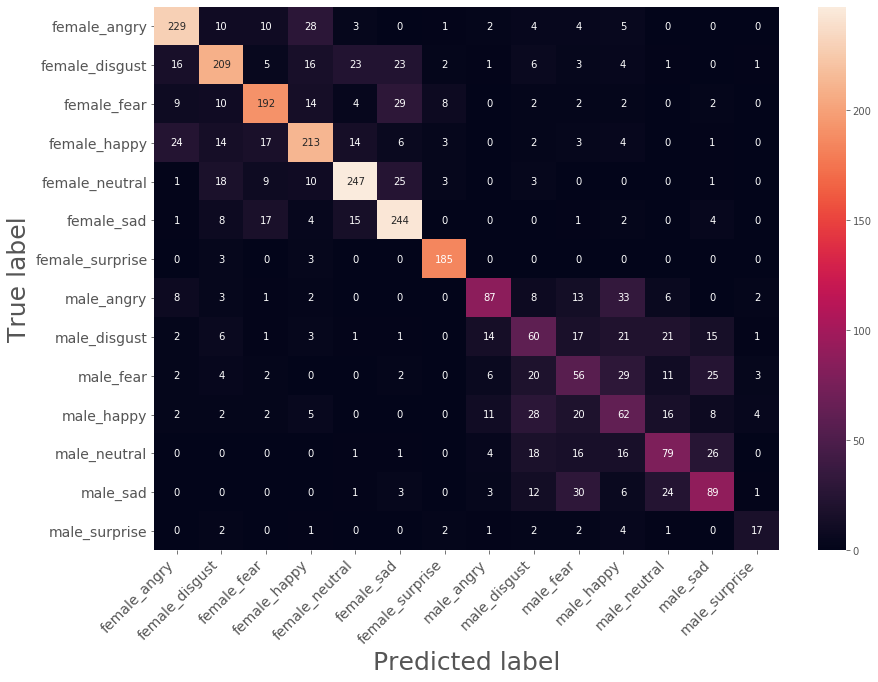

In [46]:
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [47]:
def create_plot(model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.figure(figsize = (14, 7))
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('Model Loss', fontsize = 20)
        plt.ylabel('Loss', fontsize = 15)
        plt.xlabel('Epoch', fontsize = 15)
        plt.legend(['Training Loss', 'Testing Loss'], loc='upper left', fontsize = 13)
        plt.show()



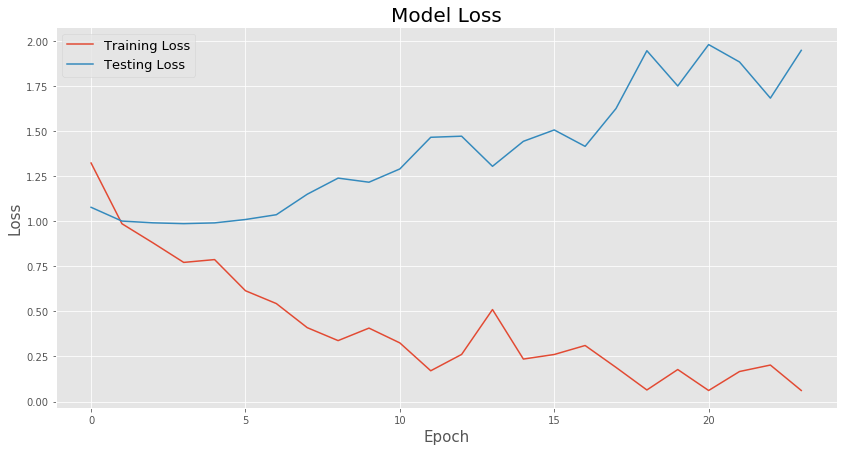

In [48]:
create_plot(h)

In [49]:
def create_plot(model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.figure(figsize = (14, 7))
        plt.plot(model_history.history['acc'])
        plt.plot(model_history.history['val_acc'])
        plt.title('Model Accuracy', fontsize = 20)
        plt.ylabel('Loss', fontsize = 15)
        plt.xlabel('Epoch', fontsize = 15)
        plt.legend(['Training Accu', 'Testing Acc'], loc='upper left', fontsize = 13)
        plt.show()



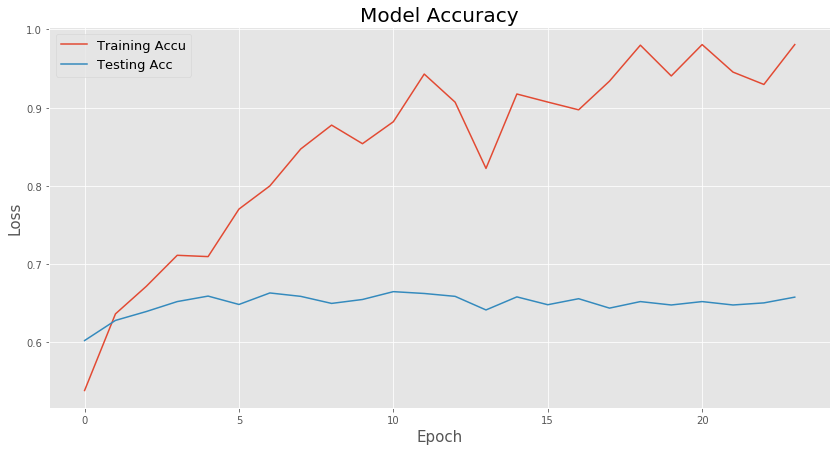

In [50]:
create_plot(h)

In [24]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.80      0.81      0.80       296
 female_disgust       0.73      0.70      0.72       310
    female_fear       0.83      0.65      0.73       274
   female_happy       0.75      0.72      0.73       301
 female_neutral       0.75      0.78      0.77       317
     female_sad       0.72      0.82      0.77       296
female_surprise       0.94      0.98      0.96       191
     male_angry       0.57      0.61      0.59       163
   male_disgust       0.38      0.47      0.42       163
      male_fear       0.42      0.26      0.32       160
     male_happy       0.40      0.36      0.38       160
   male_neutral       0.59      0.54      0.56       161
       male_sad       0.50      0.66      0.57       169
  male_surprise       0.46      0.53      0.49        32

       accuracy                           0.68      2993
      macro avg       0.63      0.64      0.63      2993
   weighted avg       0.68   